#### GNU GPL.

In [1]:
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# eBeam Lithography simulation using PSF from Casino3
##  *Part 2: PEC*

In this second demo I use the FFT deconvolution technique to find the proximity effect correction (PEC) of a given target exposure.
### Import libraries:

In [2]:
%matplotlib notebook

import os, sys, math, string
from sympy.ntheory import primefactors, factorint
from timeit import default_timer as timer #for timing

import numpy as np
from scipy.constants import e #in Coulomb
#from scipy.interpolate import interp1d

import matplotlib.pyplot as plt #for plotting

import imageio

#for CUDA:
from numba import cuda
from numba import * #I don't know why I have to split the cell here when I import all the lib *!
#continue to cell below...

In [3]:
#...from cell above
from __future__ import print_function

import pycuda.autoinit
import pycuda.driver as cudadriver
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

#for using FFT with scikitcuda:
import skcuda.fft as cu_fft
import skcuda.linalg as linalg

# lib written by me:
os.chdir('../')
import PatternGenerator as pg
from Casino import Casino3 as cs3

/home/luan/anaconda3/envs/pycudaenv_py36/lib/python3.6/site-packages/scikit_cuda-0.5.3-py3.6.egg/skcuda/cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [4]:
# some usefull functions written by me

## getting probe current on Zeiss Supra 40 SEM
### beam current (pA) at largest aperture for 30, 20, 10 and 5 kV:
MAX_CURRENT_30 = 7300 
MAX_CURRENT_20 = 4340
MAX_CURRENT_10 = 2750
MAX_CURRENT_5 = 2000

# below these two functions are for a typical SEM Zeiss Supra 40:
def getpc(kV, maxpc,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    maxpc : beam current at biggest aperture (pA).
    ap : list of aperture diameters (µm).
    example : getpc(30,7300) return an array of beam currents for different aperture sizes.'''
    im = len(ap)-2
    pc=np.array([maxpc]*(im+2))
    for ii in np.arange(im,-1,-1):
        pc[ii] = pc[ii+1]*(ap[ii]/ap[ii+1])**2
    return pc

def getpc2(kV, pci,i,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    pci : beam current (pA) at ith aperture. i=0 is the smallest aperture.
    ap : list of aperture diameters (µm).
    example : getpc(30,456,3) return an array of beam currents for different aperture sizes.'''
    assert i >= 0 and i < len(ap)
    pc=np.array([0]*len(ap))
    pc[i] = pci
    pc[-1] = pc[i]*(ap[-1]/ap[i])**2
    for ii2 in np.arange(len(ap)-2,-1,-1):
        pc[ii2] = pc[ii2+1]*(ap[ii2]/ap[ii2+1])**2
    return pc

In [5]:
## for kernel use:
def i2f(idx,WF,px_size):
    '''It is the reverse function of float2idx.'''
    return -WF/2+idx*px_size

def f2i(x,WF,px_size):
    '''It just converts a float value to index integer in the array of WF.'''
    return int((x+WF/2)/px_size)

f2i_gpu = cuda.jit(device=True)(f2i)

@cuda.jit
def pattern2matrix(dest, pattern, WF, pxs):
    '''Map the pattern to matrix data.
    It will also correct redundance dots in pattern.'''
    i = cuda.grid(1)
    ix = f2i_gpu(pattern[i,0],WF,pxs)
    iy = f2i_gpu(pattern[i,1],WF,pxs)
    dest[ix,iy] += pattern[i,2]

def psf_interp1(r,sr,M,data):
    '''You don't need to use this function.
    It's a subroutine for kernel to interpolate points in beetwen two simulated data.'''
    r_i = r/sr
    i_lo=int(r_i);i_hi = i_lo+1 if r_i > i_lo else i_lo
    if i_hi >= M:
        return 0.0
    elif i_hi == i_lo:
        return data[i_hi,1]
    else:
        slope = (data[i_hi,1]-data[i_lo,1])/(data[i_hi,0]-data[i_lo,0])
        return slope*(r-data[i_lo,0]) + data[i_lo,1]

psf_interp1_gpu = cuda.jit(device=True)(psf_interp1)

@cuda.jit
def psf_kernel(psf,point,NP,WF,pixel_size,sr,nr,simdata):
    '''This kernel stores the PSF function in the psf 2D-array.
    point: only a dot at (x=0,y=0,dose=1) the center of the writefield (WF).
    NP: number of pixel in one dimension of WF. Here we work on a square 2D-array.
    for saving the GPU time, I think it's better to give the size of the pixel instead of letting the kernel calculate it.
    sr, nr are the step and the number of points respectivly in the electron-range direction of the simulated data, simdata.
    simdata: simulated data by Casino. its shape is two columns: one for x and one for y (the deposited energy at point x).
    '''
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y
    for x in range(startX, NP, gridX):
        val_x = -WF/2 + x*pixel_size
        for y in range(startY, NP, gridY):
            val_y = -WF/2 + y*pixel_size
            r = math.sqrt((val_x-point[0])**2+(val_y-point[1])**2)
            psf[y, x] += point[2]*psf_interp1_gpu(r,sr,nr,simdata)

### I) Prepare PSF:
Same as first demo for the PSF, we import data simulated by Casino3 for our sample.

In [6]:
#SEM + EBL parameters:
Nesim=1e7 #number of simulated electron paths. Must be the same as in Casino3 software simulation parameters.
PGSpeed=6e6 #pattern generator (Raith Elphy Plus) max frequency in Hz

#semCurrentsAt30kV=np.array([24,48,196,411,1780,7300])*1e-12 #SEM currents tab in Ampere at 30 kV
semCurrentsAtkV=getpc(30,MAX_CURRENT_30)*1e-12 #SEM currents tab in Ampere at 30 kV

minimalDoses=semCurrentsAtkV/PGSpeed #in C
Nelectrons=minimalDoses/e
normalizeFactors=Nelectrons/Nesim

# import data from cs3:
os.chdir('demo')
filename='zep520_1e7_30kV_100mrad_1pt'
sim=cs3(filename)

# create electron range array for X-axis:
r= np.arange(sim.xrange[0],sim.xrange[1],sim.sx)

# create XY array (for the smallest beam current multiply y-values by normalizeFactors[0]):
yi=3;zi=3 #half thickness of resist (150 nm)
mcdata=np.c_[r,1000*sim.data[:,yi,zi]*normalizeFactors[0]] #TODO check with casino3 authors (M. Dominique Drouin,...) that the unit is in keV so *1000 to get eV

# Define: number of pixels, pixel size, etc.
sr=mcdata[1,0]-mcdata[0,0];nr=mcdata.shape[0] #step in r and number of steps
n=4
NP=n*512;WF=5000

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] indices.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))

#Map the PSF to 2D-array:
blockdim = (32, 16)
griddim = (int(NP/blockdim[0]),int(NP/blockdim[1]))
z_psf = np.zeros((NP, NP), dtype = np.float64)

# start the timer and transfert data from CPU to GPU:
start = timer()
out_gpu = cuda.to_device(z_psf)
in_gpu = cuda.to_device(mcdata)
    
# call the kernel for mapping PSF to 2D-array:
psf_kernel[griddim, blockdim](out_gpu,pg.dotPattern(0,0)[0],NP,WF,pixel_size,sr,nr,in_gpu) 

# copy the result back to CPU and release GPU memory:
out_gpu.to_host()
in_gpu.to_host()

#stop the timer and print the min, max values:
dt = timer() - start
print("z_PSF created on GPU in %f s" % dt)
log_message = f'min value = {np.min(z_psf)}; max value = {np.max(z_psf)}; sum value = {np.sum(z_psf)}.'
print(log_message)

# GPU RAM available after:
out_gpu.gpu_data._mem.free()
in_gpu.gpu_data._mem.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

#padded psf for even NP:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

z_PSF created on GPU in 0.403322 s
min value = 0.0; max value = 0.19314753607635882; sum value = 40.4588758013394.
70.6 % of device memory is free.


### II) Import target exposure
To simplify, the target exposure is given here in the filename *target_ebl_for_pec.npy*. This is the ideal exposure that we want to reach but don't know what dose to use.

But you can create your own target exposure (some suggestions to get the target exposure are in another demo)

In [7]:
filename='target_ebl_for_pec'
z_target=np.load(filename+'.npy')

<IPython.core.display.Javascript object>


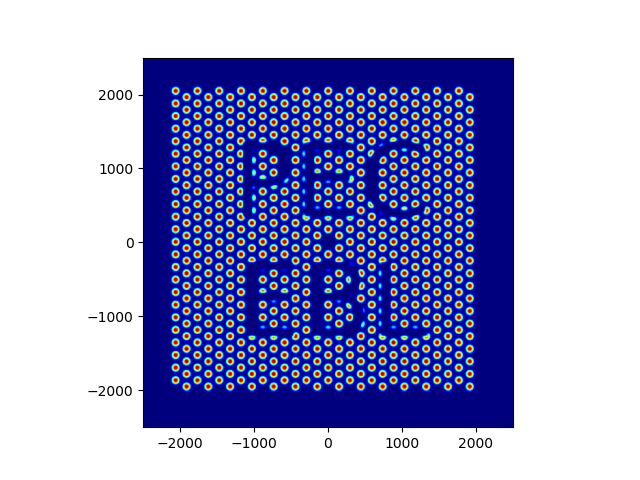

In [8]:
plt.imshow(z_target,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

### III) PEC : using cuda FFT with scikit-cuda
Deconvolution by FFT principe:
 - 1) apply FFT to the convolution kernel psf (padded)
 - 2) apply inverse Hadamard product to the previous result
 - 3) apply FFT to the target exposure z_target
 - 4) perform the point-wise multiplication of the two preceding results
 - 5) apply inverse FFT to the result of the multiplication
 
 
 The output result data is *pec.real*. This is the dose distribution we desire.

In [9]:
start = timer()

# get 1/[FFT(psf)]
# 1) apply FFT to the convolution kernel psf
print('GPU : FFT(psf) = psf in-place fft..')
tx = np.asarray(ppsf, np.complex128)
fftpsf_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(fftpsf_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(fftpsf_gpu, fftpsf_gpu, plan)

# 2) apply inverse Hadamard product to the previous result
print('CPU : 1/FFT(psf)...')
fft_psf = fftpsf_gpu.get()
fftpsf_div=1./fft_psf

#deconvolution to get dose distribution:
# 3) apply FFT to the target exposure z_target
print('GPU : FFT(T) = z_target in-place fft..')
tx = np.asarray(z_target, np.complex128)
fftztarget_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(fftztarget_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(fftztarget_gpu, fftztarget_gpu, plan)

# 4) perform the point-wise multiplication of the two preceding results
print('GPU : point-wise multiplication of two matrices...')
fftpsf_div_gpu=gpuarray.to_gpu(fftpsf_div)
linalg.init()
pec_gpu = linalg.multiply(fftztarget_gpu, fftpsf_div_gpu)

# 5) apply inverse FFT to the result of the multiplication
print('GPU : inverse FFT to get dose distribution...')
plan = cu_fft.Plan(pec_gpu.shape, np.complex128, np.complex128)
cu_fft.ifft(pec_gpu, pec_gpu, plan, True)
pec = pec_gpu.get()

dt = timer() - start
print("deconvolution done on GPU in %f s" % dt)
#winsound.Beep(freq, duration)

# check the free memory:
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

# free gpu memories:
#fftpsf_gpu.gpudata.free()
fftztarget_gpu.gpudata.free()
fftpsf_div_gpu.gpudata.free()
pec_gpu.gpudata.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

print(np.min(pec.real),np.max(pec.real),np.sum(pec.real))

GPU : FFT(psf) = psf in-place fft..
CPU : 1/FFT(psf)...
GPU : FFT(T) = z_target in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get dose distribution...
deconvolution done on GPU in 0.940799 s
50.3 % of device memory is free.
59.9 % of device memory is free.
-4.92500137894e-12 1.2611166987 995388.435397


<IPython.core.display.Javascript object>


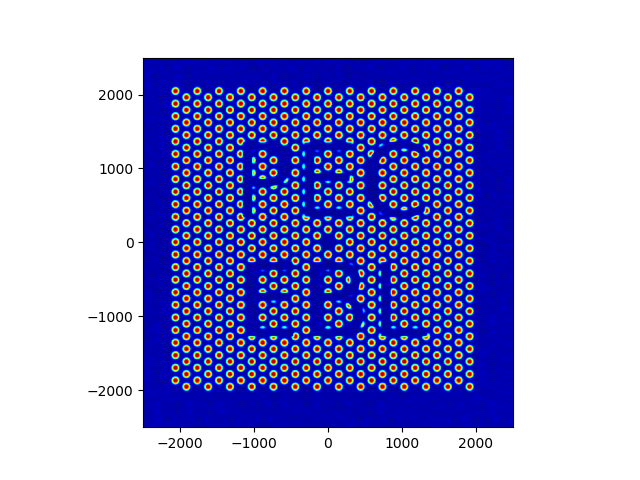

In [11]:
# plotting...
plt.imshow(pec.real,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

**Note:** In real case, the pec found by FFT deconvolution may contain negative values. We will disscuss further some suggestions to overcome this issue.

Now we can do the ebl exposure with the pec dose distribution. We must find the z_target.

### IV) Expose with PEC

In [12]:
start = timer()
#get [ TF(psf) ] and TF[ dose_dis]
#fftpsf_gpu is already calculated in previous section

print('GPU : FFT(pec.real) = dose_dis in-place fft..')
tx = np.asarray(pec.real, np.complex128)
out_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(out_gpu, out_gpu, plan)

#perform point-wise multiplication
print('GPU : point-wise multiplication of two matrices...')
linalg.init()
out_gpu = linalg.multiply(out_gpu, fftpsf_gpu)

#free fftpsf_gpu:
fftpsf_gpu.gpudata.free()

#apply inverse FFT
print('GPU : inverse FFT to get exposure energy distribution...')
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.ifft(out_gpu, out_gpu, plan, True)
z=out_gpu.get()

dt = timer() - start
print("convolution done on GPU in %f s" % dt)
#winsound.Beep(freq, duration)

free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

out_gpu.gpudata.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag)


GPU : FFT(pec.real) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 0.271314 s
56.7 % of device memory is free.
59.9 % of device memory is free.


(3.6451177870734774,
 -1.4931698116252642e-14,
 39.602477101038389,
 1.4983138424347585e-14)

<IPython.core.display.Javascript object>


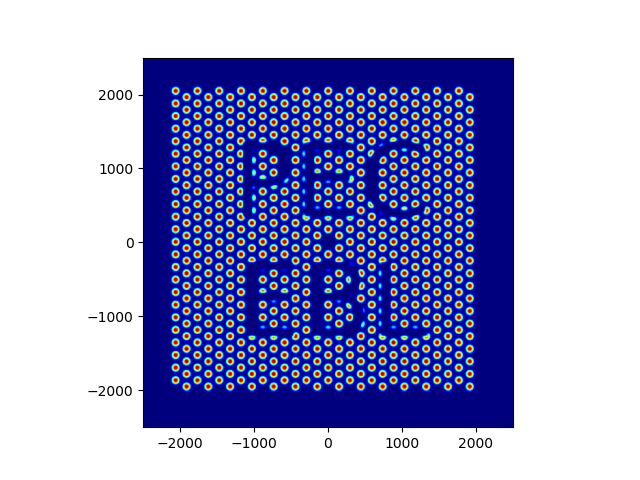

In [13]:
plt.imshow(z.real,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

<IPython.core.display.Javascript object>


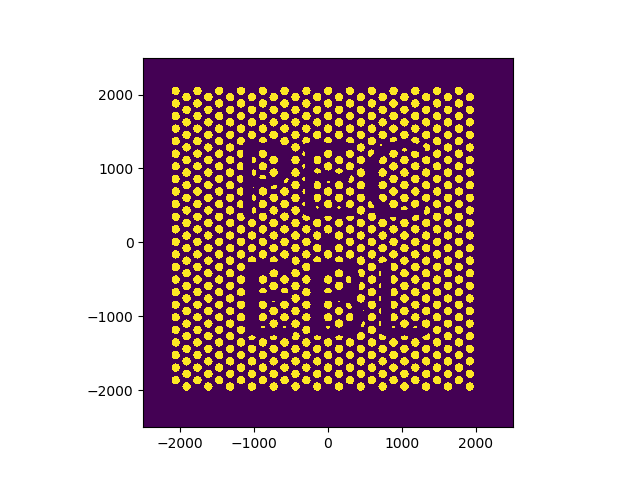

In [14]:
# Develop
th_resist=12 #clearing dose = 12 eV
z_dev = (z.real> th_resist) * z.real

z_dev[z_dev > 0] = 1

plt.imshow(z_dev,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

### 3D view
Use pyopengl and pyqygraph

In [16]:
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg
import pyqtgraph.opengl as gl

In [17]:
app = QtGui.QApplication([])

In [18]:
x=np.linspace(-WF/2,WF/2,NP)
y=np.linspace(-WF/2,WF/2,NP)

#3D GL view:
w = gl.GLViewWidget()
w.show()
w.setWindowTitle('Expo EBL')
w.setCameraPosition(distance=50)

## Add a grid to the view
g = gl.GLGridItem()
g.scale(1,1,1)
g.setDepthValue(1)  # draw grid after surfaces since they may be translucent
w.addItem(g)

cmap=plt.get_cmap('jet')
minZ=np.min(z.real);maxZ=np.max(z.real)
rgba_img=cmap((z.real-minZ)/(maxZ-minZ))

## Simple surface plot example
p1 = gl.GLSurfacePlotItem(x,y,z.real, colors=rgba_img)
#p1.translate(0, 0, -np.mean(z))
w.addItem(p1)

if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
    QtGui.QApplication.instance().exec_()
